### 1. Project Setup: Importing Libraries and Initial Configuration

This initial cell establishes the complete environment for our USD/TRY exchange rate forecasting project. It imports all the necessary libraries, covering data manipulation, natural language processing, machine learning modeling, and evaluation. It also sets up key configurations for reproducibility and text processing.

*   **Core Data Handling:**
    *   `pandas` & `numpy`: The foundational libraries for creating and manipulating DataFrames and performing numerical operations.
    *   `re` (Regular Expressions): Essential for cleaning and standardizing the raw text data from news articles.
    *   `datetime`: Crucial for working with dates, which is fundamental for merging time-series data (exchange rates) with dated news articles and for creating the sliding window.
    *   `time` & `pickle`: Used for measuring model performance (`training time`, `test time`) and for saving/loading Python objects, such as trained models.

*   **Natural Language Processing (NLP):**
    *   `TfidfVectorizer`: This is a key component for **feature extraction from texts**. It will convert raw text from news titles and articles into a meaningful numerical matrix based on term frequency-inverse document frequency (TF-IDF), which reflects how important a word is to a document in the corpus.
    *   `nltk.stopwords`: We download and load a list of common Turkish "stopwords" (e.g., *'ve', 'ile', 'bir'*). Removing these non-informative words from our text helps the model focus on the terms that carry the most predictive meaning.

*   **Machine Learning & Modeling:**
    *   A suite of powerful regression models is imported to compare and find the best performer: `LinearRegression`, `RandomForestRegressor`, `GradientBoostingRegressor`, `SVR`, and `XGBoost`. This allows for a comprehensive evaluation of different algorithmic approaches.
    *   `train_test_split`: A standard utility for splitting data. For time-series forecasting, we will need to be careful to split the data chronologically rather than randomly.

*   **Evaluation Metrics & Visualization:**
    *   `mean_absolute_error` (MAE), `r2_score`, and `mean_squared_error` are imported. These directly align with the project's required performance metrics (**MAE, R²**).
    *   `matplotlib` and `seaborn`: The standard libraries for creating plots to visualize our data and results.

*   **Global Configuration:**
    *   `RANDOM_SEED`: A fixed seed is set to ensure that any operation involving randomness (like in a RandomForestRegressor) is reproducible.
    *   `warnings.filterwarnings('ignore')`: Suppresses warnings to keep the notebook output clean.
    *   `turkish_stopwords`: The list of Turkish stopwords is loaded into memory, ready for use in the text preprocessing pipeline.

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import time
import pickle 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords') # Run this line once and then comment it out.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

# Turkish stopwords list (from NLTK or a custom list)
try:
    turkish_stopwords = stopwords.words('turkish')
except LookupError:
    import nltk
    nltk.download('stopwords')
    turkish_stopwords = stopwords.words('turkish')
# You can extend this list with custom stopwords if needed
# turkish_stopwords.extend(["bir", "ve", "ile", "ama", "ancak", "çok", "daha", "şey"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\defne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### 2. Data Loading, Cleaning, and Initial Preparation

This cell is responsible for loading the two distinct datasets—news articles and exchange rates—and performing the essential cleaning and preprocessing steps to make them compatible for merging. The primary challenge here is standardizing the date formats from different sources.

**Workflow and Key Actions:**

1.  **Loading Raw Data:**
    *   The Turkish news articles are loaded from `TurkishNewsArticles.csv` into a pandas DataFrame.
    *   The exchange rate data from the Central Bank of the Republic of Türkiye (CBRT) is loaded from `EVDS.xlsx`.
    *   Initial checks (`.columns`, `.head()`) are performed to inspect the structure and content of both raw datasets.

2.  **Date Standardization:**
    *   This is the most critical part of this cell. The project requires combining data based on dates, but the date formats are different:
        *   **News Data:** Contains dates in a complex Turkish format (e.g., "19 Mart 2021, Cuma"). A custom function `parse_turkish_news_date` is defined to handle this:
            *   It isolates the main date part by removing the day of the week.
            *   It translates Turkish month names ('Mart') into their English equivalents ('March').
            *   It then uses `pd.to_datetime` to convert the standardized string into a proper datetime object.
            *   Robust `try-except` blocks are used to handle any parsing failures gracefully, assigning `NaT` (Not a Time) to unparsable dates.
        *   **CBRT Data:** The date format is more standard, so `pd.to_datetime` can be applied directly.
    *   A new, standardized `Date_dt` column is created in both DataFrames.

3.  **Data Cleaning and Formatting:**
    *   **Column Renaming:** Columns are renamed to be more intuitive and consistent (e.g., 'TP DK USD A YTL' becomes `USD_TRY`).
    *   **Column Selection:** Only the relevant columns (`Date_dt`, `Author`, `Title`, `Text` for news; `Date_dt`, `USD_TRY` for exchange rates) are selected for the new processed DataFrames.
    *   **Handling Missing/Invalid Data:**
        *   Any rows with failed date conversions (`NaT`) are dropped from both datasets, as they cannot be used for time-series analysis.
        *   The `USD_TRY` column is converted to a numeric type. Any non-numeric entries are converted to `NaN` and subsequently dropped.

4.  **Final Verification:**
    *   The head of both processed DataFrames is printed to confirm the changes.
    *   The date ranges of both datasets are printed. This is a crucial sanity check to ensure there is an overlapping period between the news articles and the exchange rate data, which is a prerequisite for a successful merge.

By the end of this cell, we have two clean, separate DataFrames (`df_news_processed` and `df_cbrt_processed`) with a common, standardized `Date_dt` column, ready for the next step of merging and feature engineering.

In [5]:
df_news_raw = pd.read_csv("TurkishNewsArticles.csv") 
print("News data loaded successfully.")
print("News data columns:", df_news_raw.columns)
print("News data head:\n", df_news_raw.head()) 

df_cbrt_raw = pd.read_excel("EVDS.xlsx") 
print("\nExchange rate data loaded successfully.")
print("Exchange rate data columns:", df_cbrt_raw.columns)
print("Exchange rate data head:\n", df_cbrt_raw.head()) 

df_news = df_news_raw.copy()
df_cbrt = df_cbrt_raw.copy()

# Function to process dates in news data (for "19 Mart 2021, Cuma" format)
def parse_turkish_news_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        # Drop the part containing the day name like ", Cuma"
        date_part = str(date_str).split(',')[0].strip()
        
        # Convert Turkish month names to English or numbers (English is more reliable for Pandas' %B format)
        turkish_to_english_months = {
            'Ocak': 'January', 'Şubat': 'February', 'Mart': 'March', 'Nisan': 'April',
            'Mayıs': 'May', 'Haziran': 'June', 'Temmuz': 'July', 'Ağustos': 'August',
            'Eylül': 'September', 'Ekim': 'October', 'Kasım': 'November', 'Aralık': 'December'
        }
        
        for tr_month, en_month in turkish_to_english_months.items():
            if tr_month in date_part:
                date_part = date_part.replace(tr_month, en_month)
                break
        
        # Now try to parse in 'DD MonthName YYYY' format (e.g., '19 March 2021')
        return pd.to_datetime(date_part, format='%d %B %Y', errors='coerce')
    except Exception as e:
        # print(f"Could not parse date string: {date_str} with custom logic. Error: {e}")
        # Alternatively, we can try Pandas' generic parsing, but the format is very specific.
        try:
            return pd.to_datetime(date_part, errors='coerce') # Generic attempt
        except:
            return pd.NaT

print("\nParsing news dates...")
df_news['Date_dt'] = df_news['date'].apply(parse_turkish_news_date)

print("Parsing exchange rate dates...")
df_cbrt['Date_dt'] = pd.to_datetime(df_cbrt['Tarih'], errors='coerce') 

print("\n--- Post-Date Conversion Check ---")
print("News Data Sample with 'Date_dt':")
print(df_news[['date', 'Date_dt']].head())
print(f"NaNs in news 'Date_dt' after parsing: {df_news['Date_dt'].isnull().sum()} out of {len(df_news)}")

print("\nExchange Rate Data Sample with 'Date_dt':")
print(df_cbrt[['Tarih', 'Date_dt']].head())
print(f"NaNs in CBRT 'Date_dt' after parsing: {df_cbrt['Date_dt'].isnull().sum()} out of {len(df_cbrt)}")

# Rename columns
df_news.rename(columns={'author': 'Author', 'title': 'Title', 'text': 'Text'}, inplace=True)
# It appears as 'TP DK USD A YTL' in your sample output, so I'm using that.
df_cbrt.rename(columns={'TP DK USD A YTL': 'USD_TRY'}, inplace=True) 

# Select relevant columns and copy
df_news_processed = df_news[['Date_dt', 'Author', 'Title', 'Text']].copy()
df_cbrt_processed = df_cbrt[['Date_dt', 'USD_TRY']].copy()

# Drop rows with NaT (Not a Time) in the Date_dt column (failed date conversions)
df_news_processed.dropna(subset=['Date_dt'], inplace=True)
df_cbrt_processed.dropna(subset=['Date_dt'], inplace=True)

print(f"\nShape of news_processed after dropping NaT dates: {df_news_processed.shape}")
print(f"Shape of cbrt_processed after dropping NaT dates: {df_cbrt_processed.shape}")


# Convert USD_TRY column to numeric type, making errors NaT
df_cbrt_processed['USD_TRY'] = pd.to_numeric(df_cbrt_processed['USD_TRY'], errors='coerce')
# Drop rows with NaT in USD_TRY (invalid exchange rate values)
df_cbrt_processed.dropna(subset=['USD_TRY'], inplace=True)

print(f"Shape of cbrt_processed after converting USD_TRY to numeric and dropping NaNs: {df_cbrt_processed.shape}")

print("\nProcessed News Data Head (before merge):")
print(df_news_processed.head())
print("\nProcessed Exchange Rate Data Head (before merge):")
print(df_cbrt_processed.head())

# Check date ranges (an important step before merging)
if not df_news_processed.empty and not df_cbrt_processed.empty:
    print("\nDate range in processed news data:", df_news_processed['Date_dt'].min(), "to", df_news_processed['Date_dt'].max())
    print("Date range in processed CBRT data:", df_cbrt_processed['Date_dt'].min(), "to", df_cbrt_processed['Date_dt'].max())
else:
    if df_news_processed.empty:
        print("\nWARNING: News data is empty after date processing and NaT drop.")
    if df_cbrt_processed.empty:
        print("\nWARNING: Exchange rate data is empty after date processing and NaT/NaN drop.")

News data loaded successfully.
News data columns: Index(['date', 'author', 'title', 'link', 'text'], dtype='object')
News data head:
                       date         author  \
0       19 Mart 2021, Cuma  MEHMET BARLAS   
1   18 Mart 2021, Perşembe  MEHMET BARLAS   
2   17 Mart 2021, Çarşamba  MEHMET BARLAS   
3       16 Mart 2021, Salı  MEHMET BARLAS   
4  15 Mart 2021, Pazartesi  MEHMET BARLAS   

                                               title  \
0  Türk siyasetinde Devlet Bahçeli bir tutarlılık...   
1  Amerikan iç politikasında kimin kimi hedef ala...   
2  Amerikalılar, yalancı Amerikan başkanlarını ar...   
3  Darbeler geçmişte Türkiye’nin dış politikasını...   
4  Müflis Yunanistan, Türkiye’ye gövde gösterisi ...   

                                                link  \
0  https://www.sabah.com.tr/yazarlar/barlas/2021/...   
1  https://www.sabah.com.tr/yazarlar/barlas/2021/...   
2  https://www.sabah.com.tr/yazarlar/barlas/2021/...   
3  https://www.sabah.com.tr/yazarl

### 3. Merging Datasets and Text Preprocessing

This cell combines the prepared news and exchange rate data into a single, unified DataFrame. It then performs the necessary text cleaning and preprocessing to prepare the news content for feature extraction.

**Key Steps in the Workflow:**

1.  **Merging DataFrames:**
    *   An **inner merge** is performed on the `Date_dt` column. This is a critical decision: it ensures that our final dataset only contains dates for which we have **both** news articles and an exchange rate value. This aligns the two disparate data sources into a cohesive time-series dataset.
    *   The merged DataFrame is then sorted by date to establish a clear chronological order, which is fundamental for any time-series analysis or forecasting task.

2.  **Handling Missing Values:**
    *   After the merge, any remaining missing values are handled:
        *   `Author`, `Title`, and `Text` `NaN`s are filled with "Unknown" or empty strings. This prevents errors during text processing.
        *   `USD_TRY` missing values are handled using a **forward fill (`ffill`)**. This is a common and logical strategy for time-series data, as it assumes the exchange rate on a non-trading day (e.g., a weekend) is the same as the last known value. Any `NaN`s at the very beginning of the series are dropped.

3.  **Text Combination and Cleaning:**
    *   **Feature Engineering:** The `Title` and `Text` columns are combined into a single `Full_Text` column. This consolidates all textual information for a given day into one place, creating a richer input for our NLP model.
    *   **Cleaning Pipeline (`clean_text_turkish`):** A dedicated function is applied to the `Full_Text` to create a `Cleaned_Text` column. This is a standard NLP preprocessing pipeline that performs the following essential steps:
        1.  **Lowercasing:** Converts all text to lowercase to ensure uniformity (e.g., "Dolar" and "dolar" are treated as the same word).
        2.  **Removing Punctuation:** Strips out characters like commas, periods, and exclamation marks.
        3.  **Removing Numbers:** Eliminates digits, as they typically do not carry semantic meaning for this task.
        4.  **Removing Stopwords:** Removes common, non-informative Turkish words (e.g., *'ve', 'ile', 'ama'*) using the `turkish_stopwords` list defined earlier. This helps the model focus on the most meaningful terms.

4.  **Final Checks:**
    *   The head of the final merged and cleaned DataFrame is displayed to verify the results.
    *   A critical check is included to ensure the DataFrame is not empty after the merge, which would indicate a fatal issue with non-overlapping data.

By the end of this cell, we have a single, chronologically sorted DataFrame (`df_merged`) containing the target variable (`USD_TRY`) and the cleaned, preprocessed text (`Cleaned_Text`) ready for the next stage: **feature extraction from text**.

In [6]:
# Using an inner merge to keep only dates present in both datasets
df_merged = pd.merge(df_news_processed, df_cbrt_processed, on="Date_dt", how="inner")

# Sort by date to ensure chronological order, crucial for time series
df_merged.sort_values(by='Date_dt', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

# Handle missing values
print("\nMissing values in merged data before handling:")
print(df_merged.isnull().sum())

df_merged['Author'].fillna("Unknown", inplace=True)
df_merged['Title'].fillna("", inplace=True) # Fill NaN titles with empty string
df_merged['Text'].fillna("", inplace=True)   # Fill NaN texts with empty string

# We can use forward fill for time series data.
df_merged['USD_TRY'].fillna(method='ffill', inplace=True)
# If there are still NaNs at the beginning after ffill, drop those rows
df_merged.dropna(subset=['USD_TRY'], inplace=True)

# Combine 'Title' and 'Text' into 'Full_Text'
df_merged['Full_Text'] = df_merged['Title'] + " " + df_merged['Text']

# Text cleaning function
def clean_text_turkish(text):
    text = str(text).lower() # Convert to string and then lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)     # Remove numbers
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in turkish_stopwords])
    return text

df_merged['Cleaned_Text'] = df_merged['Full_Text'].apply(clean_text_turkish)

# Rename 'Date_dt' to 'Date' for clarity
df_merged.rename(columns={'Date_dt': 'Date'}, inplace=True)

print("\nMerged and Processed Data Head:")
print(df_merged[['Date', 'USD_TRY', 'Cleaned_Text']].head())
print(f"\nShape of merged data: {df_merged.shape}")

if df_merged.empty:
    print("\nCRITICAL ERROR: Merged dataframe is empty. This could be due to:")
    print("1. No overlapping dates between news and exchange rate data.")
    print("2. Issues in date parsing leading to no matches.")
    print("3. All 'USD_TRY' values being non-numeric or NaN after conversion.")
    print("Please check your input data and date formats.")
    # exit() # Halt execution if no data to process


Missing values in merged data before handling:
Date_dt    0
Author     0
Title      0
Text       0
USD_TRY    0
dtype: int64

Merged and Processed Data Head:
        Date  USD_TRY                                       Cleaned_Text
0 2017-01-11   3.7620  ilker ortagille sohbet zamanı merhabalar efend...
1 2017-01-18   3.7826  zeka belirtileri bazen kendimizi avutmak yalan...
2 2017-01-25   3.7523  dünyanın fit insanı insanlar bana sürekli kada...
3 2017-02-01   3.7874  mavi tık görüldü merhaba sayın günaydınla kant...
4 2017-02-08   3.7095  besinvivor milyonları ekranlar başına kilitley...

Shape of merged data: (805, 7)


### 4. Text Feature Extraction (TF-IDF) and Data Splitting

This cell performs two critical operations: it splits the data into training and testing sets and then converts the raw text data into a numerical format that machine learning models can understand.

**Workflow and Key Actions:**

1.  **Data Splitting for Time-Series:**
    *   The dataset is split into training (80%) and testing (20%) sets using `train_test_split`.
    *   **Crucially, `shuffle=False` is used.** This is a fundamental requirement for time-series forecasting. It ensures that the data is split chronologically, with the training set containing earlier data and the test set containing later data. This mimics a real-world scenario where we train on past data to predict the future. Shuffling would destroy the temporal sequence and lead to data leakage, making the model evaluation invalid.
    *   The text data, target variable (`USD_TRY`), and corresponding dates are all split consistently.

2.  **Text-to-Numeric Conversion using TF-IDF:**
    *   This is the core of the **feature extraction from texts** requirement. A `TfidfVectorizer` is initialized to convert the `Cleaned_Text` into a matrix of TF-IDF features.
    *   **TF-IDF (Term Frequency-Inverse Document Frequency)** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. It increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This helps to adjust for the fact that some words appear more frequently in general.
    *   **Vectorizer Configuration:**
        *   `max_features=500`: Limits the vocabulary to the 500 most frequent terms, which helps control the dimensionality of the feature space and prevents overfitting.
        *   `min_df=3`: Ignores terms that have a document frequency strictly lower than 3. This filters out very rare or potentially misspelled words.
        *   `ngram_range=(1,1)`: Considers only single words (unigrams) as features. This could be changed to `(1,2)` to also include two-word phrases (bigrams).

3.  **Fitting and Transforming:**
    *   **`fit()` on Training Data ONLY:** The vectorizer is **fitted only on the training text (`X_text_train_raw`)**. This is a critical step to prevent data leakage. The vocabulary and IDF weights are learned exclusively from the training data.
    *   **`transform()` on Both Sets:** The fitted vectorizer is then used to transform both the training and testing text into numerical feature matrices (`X_train_text_features`, `X_test_text_features`). The test data is transformed using the vocabulary learned from the training data.
    *   The resulting sparse matrices are converted to dense pandas DataFrames for easier inspection.

4.  **Saving the Vectorizer:**
    *   The trained `TfidfVectorizer` is saved to a file (`tfidf_vectorizer.pkl`) using `pickle`. This is important for deployment: when making predictions on new, unseen news articles in the future, we must use the exact same vectorizer to ensure the features are created consistently.

At the end of this cell, our text data has been transformed into a numerical feature matrix, and the data is properly split for the upcoming modeling and evaluation stages.

In [7]:
if not df_merged.empty:
    # Prepare data for splitting
    X_text_raw = df_merged['Cleaned_Text']
    y = df_merged['USD_TRY']
    dates_series = df_merged['Date'] # Keep dates for later visualization

    X_text_train_raw, X_text_test_raw, y_train, y_test, dates_train, dates_test = train_test_split(
        X_text_raw,
        y,
        dates_series,
        test_size=0.2,
        shuffle=False, 
        random_state=RANDOM_SEED 
    )

    print(f"\nTraining set size: {len(X_text_train_raw)}, Test set size: {len(X_text_test_raw)}")
    
    if X_text_train_raw.empty or X_text_test_raw.empty:
        print("ERROR: Training or testing text data is empty after split. Check data size and split ratio.")
    else:
        tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=3, ngram_range=(1,1)) # Example parameters

        # Fit the vectorizer ONLY on the training text data
        tfidf_vectorizer.fit(X_text_train_raw)

        # Transform both training and testing text data
        X_train_text_features = tfidf_vectorizer.transform(X_text_train_raw)
        X_test_text_features = tfidf_vectorizer.transform(X_text_test_raw)
        
        df_X_train_text = pd.DataFrame(X_train_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_text_train_raw.index)
        df_X_test_text = pd.DataFrame(X_test_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_text_test_raw.index)

        print("\nSample of TF-IDF features for training data:")
        print(df_X_train_text.head())

        # Save the TfidfVectorizer
        with open('tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf_vectorizer, f)
        print("\nTfidfVectorizer saved to 'tfidf_vectorizer.pkl'")
else:
    print("\nSkipping Feature Extraction as merged data is empty.")
    # Initialize empty DataFrames to prevent errors in later steps if script continues
    df_X_train_text = pd.DataFrame()
    df_X_test_text = pd.DataFrame()
    y_train = pd.Series(dtype='float64')
    y_test = pd.Series(dtype='float64')
    dates_train = pd.Series(dtype='datetime64[ns]')
    dates_test = pd.Series(dtype='datetime64[ns]')


Training set size: 644, Test set size: 161

Sample of TF-IDF features for training data:
   abd  abdnin      adam      adet       adı  adım  adına  ahmet  ait   ak  \
0  0.0     0.0  0.000000  0.000000  0.082137   0.0    0.0    0.0  0.0  0.0   
1  0.0     0.0  0.000000  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
2  0.0     0.0  0.000000  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
3  0.0     0.0  0.058181  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
4  0.0     0.0  0.000000  0.389735  0.000000   0.0    0.0    0.0  0.0  0.0   

   ...  üzerinden   üzerine   üç   şekilde      şeyi    şeyler  şiir  \
0  ...   0.000000  0.000000  0.0  0.000000  0.000000  0.000000   0.0   
1  ...   0.000000  0.000000  0.0  0.000000  0.000000  0.000000   0.0   
2  ...   0.000000  0.000000  0.0  0.089803  0.000000  0.069096   0.0   
3  ...   0.057114  0.000000  0.0  0.044871  0.067224  0.000000   0.0   
4  ...   0.000000  0.083952  0.0  0.144372  0.000000  0.000000   0.0   

      şi

### 5. Feature Engineering: Implementing the Sliding Window with Lagged Features

This cell implements one of the most critical project requirements: using a **sliding window to forecast the USD/TRY rate**. This is achieved by creating "lagged features," which provide the model with historical context about the exchange rate's recent behavior.

**Key Steps and Concepts:**

1.  **The "Sliding Window" Concept (Lagged Features):**
    *   The core idea is that the exchange rate for a given day (*t*) is highly influenced by the rates of the preceding days (*t-1, t-2, t-3,* etc.).
    *   A helper function `create_lagged_features` is defined to generate these features. It takes a time series and creates new columns, where each column is the series shifted by a certain number of days (a "lag").
    *   The `window_size` parameter (e.g., `3`) determines how many past days of data will be used as features for predicting the current day's rate.

2.  **Creating Lags for Training Data:**
    *   The process is straightforward for the training set. The function is applied to `y_train` to create lagged features based on the historical values *within* the training set itself.

3.  **Creating Lags for Test Data (Preventing Data Leakage):**
    *   This is a critical and nuanced step. We cannot simply apply the `shift()` function to `y_test` alone. The first data point in `y_test` needs the exchange rate from the *last day of `y_train`* as its `lag_1` feature.
    *   To solve this correctly and **avoid data leakage**, the code temporarily concatenates the end of the training data (`y_train.iloc[-window_size:]`) with the entire test data (`y_test`). The lag function is applied to this combined series, and then only the rows corresponding to the original test set are selected. This ensures a continuous and valid history for every point in the test set.

4.  **Combining Feature Sets:**
    *   The newly created lagged features (`df_y_train_lags`, `df_y_test_lags`) are concatenated with the text-based TF-IDF features (`df_X_train_text`, `df_X_test_text`).
    *   This creates our final, powerful, hybrid feature matrices: `X_train_final` and `X_test_final`. These matrices now contain both linguistic signals from news articles and time-series momentum from past exchange rates.

5.  **Handling `NaN` Values:**
    *   The `shift()` operation naturally creates `NaN` (Not a Number) values at the beginning of the series, as these initial data points do not have a complete history.
    *   These rows are unusable for training, so they are dropped using `dropna()`.
    *   Crucially, the corresponding rows in the target variables (`y_train`, `y_test`) and the date series are also removed to maintain perfect alignment between features and targets.

6.  **Saving Final Datasets:**
    *   The final, model-ready feature and target datasets are saved to CSV files. This is good practice for reproducibility and allows for easy reloading without re-running the entire preprocessing pipeline.

By the end of this cell, we have successfully engineered a comprehensive feature set that captures both textual sentiment and time-series dynamics. This hybrid dataset is now fully prepared for the model training and evaluation phase.

In [8]:
def create_lagged_features(series, max_lag, name='lag'):
    """Creates a DataFrame of lagged features for a given series."""
    df_lags = pd.DataFrame(index=series.index) # Ensure index is preserved
    for lag in range(1, max_lag + 1):
        df_lags[f'{name}_{lag}'] = series.shift(lag)
    return df_lags

if not y_train.empty and not y_test.empty: # Proceed only if y_train and y_test are not empty
    window_size = 3 # Example: use the exchange rates from the last 3 days as features

    # Create lagged features for y_train
    # These lags are based on values within y_train itself.
    df_y_train_lags = create_lagged_features(y_train, window_size, 'USD_TRY_lag')

    # Create lagged features for y_test
    # To avoid data leakage, lags for the start of y_test must come from the end of y_train.
    # Concatenate the end of y_train with y_test to correctly calculate lags for the initial part of y_test.
    if len(y_train) >= window_size:
        historical_data_for_test_lags = pd.concat([y_train.iloc[-window_size:], y_test])
        all_lags_temp = create_lagged_features(historical_data_for_test_lags, window_size, 'USD_TRY_lag')
        df_y_test_lags = all_lags_temp.iloc[window_size:] # Remove the rows corresponding to y_train part
        df_y_test_lags.index = y_test.index # Realign index with y_test
    else:
        print(f"Warning: Training data size ({len(y_train)}) is smaller than window_size ({window_size}). Cannot create sufficient historical context for test lags.")
        print("Proceeding without lags for test set, or consider a smaller window or more training data.")
        # Create empty lag dataframe for test to avoid errors, or handle this case more robustly
        df_y_test_lags = pd.DataFrame(index=y_test.index)
        for lag in range(1, window_size + 1):
            df_y_test_lags[f'USD_TRY_lag_{lag}'] = np.nan


    # Concatenate text features with lagged currency features
    X_train_final = pd.concat([df_X_train_text, df_y_train_lags], axis=1)
    X_test_final = pd.concat([df_X_test_text, df_y_test_lags], axis=1)

    # Handle NaNs created by lagging (at the beginning of the series)
    # We need to drop these rows and also adjust y_train and y_test accordingly.
    print(f"\nNaNs in X_train_final before dropping: {X_train_final.isnull().any(axis=1).sum()}")
    # Store original indices to filter y_train and dates_train
    original_train_indices = X_train_final.index
    X_train_final.dropna(inplace=True)
    # Filter y_train and dates_train to match the rows kept in X_train_final
    y_train = y_train.loc[X_train_final.index]
    dates_train = dates_train.loc[X_train_final.index]
    print(f"NaNs in X_train_final after dropping: {X_train_final.isnull().any(axis=1).sum()}")

    print(f"\nNaNs in X_test_final before dropping: {X_test_final.isnull().any(axis=1).sum()}")
    original_test_indices = X_test_final.index
    X_test_final.dropna(inplace=True)
    y_test = y_test.loc[X_test_final.index]
    dates_test = dates_test.loc[X_test_final.index]
    print(f"NaNs in X_test_final after dropping: {X_test_final.isnull().any(axis=1).sum()}")

    print("\nSample of final training features (TF-IDF + Lags):")
    print(X_train_final.head())
    print(f"Shape of X_train_final: {X_train_final.shape}, Shape of y_train: {y_train.shape}")
    print(f"Shape of X_test_final: {X_test_final.shape}, Shape of y_test: {y_test.shape}")

    # Save the transformed datasets as per instructions
    if not X_train_final.empty:
        X_train_final.to_csv("transformed_train_features.csv", index=False)
        y_train.to_csv("transformed_train_target.csv", index=False, header=['USD_TRY'])
        print("\nTransformed training data saved.")
    if not X_test_final.empty:
        X_test_final.to_csv("transformed_test_features.csv", index=False)
        y_test.to_csv("transformed_test_target.csv", index=False, header=['USD_TRY'])
        print("Transformed test data saved.")

else:
    print("\nSkipping Feature Engineering (Lags) as training/test target data is empty.")
    # Ensure X_train_final and X_test_final are initialized if previous steps were skipped
    if 'X_train_final' not in locals(): X_train_final = pd.DataFrame()
    if 'X_test_final' not in locals(): X_test_final = pd.DataFrame()


NaNs in X_train_final before dropping: 3
NaNs in X_train_final after dropping: 0

NaNs in X_test_final before dropping: 0
NaNs in X_test_final after dropping: 0

Sample of final training features (TF-IDF + Lags):
   abd  abdnin      adam      adet       adı  adım  adına  ahmet  ait   ak  \
3  0.0     0.0  0.058181  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
4  0.0     0.0  0.000000  0.389735  0.000000   0.0    0.0    0.0  0.0  0.0   
5  0.0     0.0  0.000000  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
6  0.0     0.0  0.000000  0.000000  0.000000   0.0    0.0    0.0  0.0  0.0   
7  0.0     0.0  0.000000  0.000000  0.049071   0.0    0.0    0.0  0.0  0.0   

   ...   şekilde      şeyi  şeyler  şiir     şimdi  şubat     şöyle  \
3  ...  0.044871  0.067224     0.0   0.0  0.092026    0.0  0.000000   
4  ...  0.144372  0.000000     0.0   0.0  0.000000    0.0  0.095413   
5  ...  0.000000  0.106769     0.0   0.0  0.000000    0.0  0.000000   
6  ...  0.030443  0.000000     0.

### 6. Model Training, Evaluation, and Comparison

This cell is the core of the machine learning process. It takes the final, engineered feature sets (`X_train_final`, `X_test_final`) and uses them to train, evaluate, and compare a variety of regression models. The goal is to identify which algorithm performs best on our specific forecasting task.

**Workflow and Key Actions:**

1.  **Defining the Models:**
    *   A dictionary of several powerful regression models is defined. This includes:
        *   `Linear Regression`: A simple, baseline model.
        *   `Random Forest Regressor`: An ensemble method known for its robustness and ability to handle complex interactions.
        *   `SVR` (Support Vector Regressor): A model effective in high-dimensional spaces.
        *   `Gradient Boosting Regressor`: A powerful ensemble technique that builds models sequentially.
        *   `XGBoost`: An optimized and highly efficient implementation of gradient boosting, often a top performer in competitions.
    *   This diverse selection allows us to test a range of different modeling philosophies.

2.  **Iterative Training and Prediction:**
    *   The code iterates through each model in the dictionary. For each one:
        *   **Training:** The `model.fit()` method is called to train the model on the `X_train_final` features and `y_train` targets. The **Training Time** is measured for this step.
        *   **Prediction:** The trained model is then used to make predictions on the unseen `X_test_final` data. The **Test (Prediction) Time** is measured for this step.

3.  **Performance Evaluation:**
    *   The model's predictions (`y_pred`) are compared against the actual test set values (`y_test`) using the project's required performance metrics:
        *   **`MAE` (Mean Absolute Error):** The average absolute difference between the predicted and actual values. It's an easily interpretable metric in the same units as the target (USD/TRY).
        *   **`R²` (R-squared):** The proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to 1 indicates a better fit.
        *   **`MAPE` (Mean Absolute Percentage Error):** The average absolute percentage difference between predicted and actual values. It's a useful relative measure of error. A robust calculation is used to prevent division by zero.
    *   `RMSE` (Root Mean Squared Error) is also calculated as it's a common metric that penalizes larger errors more heavily.

4.  **Results Aggregation and Comparison:**
    *   The performance metrics and timings for each model are stored in a list of dictionaries (`results_list`).
    *   This list is then converted into a `pandas` DataFrame (`df_results`) for easy viewing and comparison.
    *   The final DataFrame is printed, sorted by MAPE, allowing for a clear and direct **performance comparison** to identify the best-performing model based on this key metric.

By the end of this cell, we have a comprehensive, quantitative comparison of all tested models, fulfilling a major project requirement and providing a clear answer as to which algorithm is most effective for this USD/TRY forecasting task.

In [9]:
results_list = [] # Changed variable name from 'results' to 'results_list' to avoid potential conflict

if not X_train_final.empty and not y_train.empty and not X_test_final.empty and not y_test.empty:
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=100, n_jobs=-1),
        "SVR": SVR(), # May require hyperparameter tuning (C, epsilon, kernel)
        "Gradient Boosting": GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=100),
        "XGBoost": xgb.XGBRegressor(random_state=RANDOM_SEED, n_estimators=100, objective='reg:squarederror', n_jobs=-1)
    }

    for model_name, model in models.items():
        print(f"\n--- Training {model_name} ---")
        
        start_train_time = time.time()
        model.fit(X_train_final, y_train)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        
        start_test_time = time.time()
        y_pred = model.predict(X_test_final)
        end_test_time = time.time()
        test_time = end_test_time - start_test_time
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # Calculate MAPE, handling potential division by zero if y_test contains 0
        # (Unlikely for exchange rates, but good practice)
        mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-6, y_test))) * 100 # Add small epsilon for y_test == 0
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results_list.append({
            "Model": model_name,
            "MAE": mae,
            "R2": r2,
            "MAPE (%)": mape,
            "RMSE": rmse,
            "Training Time (s)": train_time,
            "Test (Prediction) Time (s)": test_time
        })
        
        print(f"{model_name} - MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%, RMSE: {rmse:.4f}")
        print(f"Training Time: {train_time:.4f}s, Test Time: {test_time:.4f}s")

    df_results = pd.DataFrame(results_list)
    print("\n--- Model Comparison Table ---")
    # Sort by MAPE (lower is better) as per grading criteria
    print(df_results.sort_values(by="MAPE (%)"))
else:
    print("\nSkipping Model Training as processed feature sets are empty.")
    df_results = pd.DataFrame(columns=["Model", "MAE", "R2", "MAPE (%)", "RMSE", "Training Time (s)", "Test (Prediction) Time (s)"])


--- Training Linear Regression ---
Linear Regression - MAE: 0.1518, R2: -8.0431, MAPE: 2.01%, RMSE: 0.1912
Training Time: 0.0897s, Test Time: 0.0030s

--- Training Random Forest ---
Random Forest - MAE: 0.0153, R2: 0.8536, MAPE: 0.20%, RMSE: 0.0243
Training Time: 0.7957s, Test Time: 0.0287s

--- Training SVR ---
SVR - MAE: 0.0164, R2: 0.8536, MAPE: 0.22%, RMSE: 0.0243
Training Time: 0.0215s, Test Time: 0.0057s

--- Training Gradient Boosting ---
Gradient Boosting - MAE: 0.0203, R2: 0.7533, MAPE: 0.27%, RMSE: 0.0316
Training Time: 1.8494s, Test Time: 0.0000s

--- Training XGBoost ---
XGBoost - MAE: 0.0259, R2: 0.6760, MAPE: 0.34%, RMSE: 0.0362
Training Time: 1.2268s, Test Time: 0.1112s

--- Model Comparison Table ---
               Model       MAE        R2  MAPE (%)      RMSE  \
1      Random Forest  0.015292  0.853588  0.202455  0.024324   
2                SVR  0.016402  0.853569  0.218554  0.024326   
3  Gradient Boosting  0.020340  0.753333  0.269398  0.031572   
4            XGBo

### 7. Identifying and Saving the Best Model

This final code cell concludes the modeling phase of the project. It programmatically identifies the best-performing model based on the results from the previous step and saves this trained model to a file for future use.

**Key Actions:**

1.  **Identifying the Best Model:**
    *   The `df_results` DataFrame, which contains the performance metrics for all tested models, is analyzed.
    *   The model with the **lowest Mean Absolute Percentage Error (MAPE)** is identified as the "best model." MAPE is chosen as the primary selection criterion because it provides a relative measure of error, which is often very intuitive for financial forecasting.
    *   The name and MAPE score of the best model are printed for confirmation.

2.  **Retrieving the Trained Model Instance:**
    *   The code retrieves the actual, fully trained model object from the `models` dictionary, which was populated and trained in the previous cell.

3.  **Saving the Model for Deployment:**
    *   Using the `pickle` library, the best-performing model object (`best_model_instance`) is serialized and saved to a file named `best_forecasting_model.pkl`.
    *   This is a crucial step for **deployment and reproducibility**. By saving the trained model, we can later load it directly to make predictions on new, unseen data without needing to re-run the entire data processing and training pipeline. This makes the model portable and ready for use in a production environment or a real-world application.

This cell effectively completes the core machine learning workflow, leaving us with a tangible artifact: a saved model file that encapsulates all the learning from our combined news and exchange rate data.

In [10]:
best_model_instance = None
best_model_name = None

if not df_results.empty:
    # Find the best model based on MAPE (lowest MAPE)
    best_model_row = df_results.loc[df_results['MAPE (%)'].idxmin()]
    best_model_name = best_model_row['Model']
    
    # Retrieve the trained model instance from the 'models' dictionary
    # This requires 'models' to be in scope and contain the trained instances.
    # Ensure 'models' dictionary stores the *trained* models.
    # The loop above already fits the models, so they are trained.
    best_model_instance = models[best_model_name]

    print(f"\nBest Model (according to MAPE): {best_model_name}")
    print(f"Best Model MAPE: {best_model_row['MAPE (%)']:.2f}%")

    # Save the best performing model
    with open('best_forecasting_model.pkl', 'wb') as f:
        pickle.dump(best_model_instance, f)
    print(f"'{best_model_name}' model saved as 'best_forecasting_model.pkl'")
else:
    print("\nNo models were trained, so no best model to save.")


Best Model (according to MAPE): Random Forest
Best Model MAPE: 0.20%
'Random Forest' model saved as 'best_forecasting_model.pkl'


### 8. Results Visualization and Model Interpretation

After identifying and saving the best model, this cell focuses on creating insightful visualizations to better understand its performance and behavior. These plots provide a qualitative assessment that complements the quantitative metrics calculated earlier.

**Visualizations and Their Purpose:**

1.  **Correlation Heatmap:**
    *   **What it shows:** This heatmap visualizes the Pearson correlation between the lagged (historical) USD/TRY features and the target variable (the next day's USD/TRY rate) using the training data.
    *   **Purpose:** It helps to visually confirm the core assumption of our time-series model: that recent past values are strongly correlated with the present value. We expect to see a strong positive correlation between `TARGET_USD_TRY` and `USD_TRY_lag_1`, with the correlation decreasing as the lag increases.

2.  **Feature Importance Plot:**
    *   **What it shows:** If the best-performing model is a tree-based ensemble (like Random Forest or XGBoost), this bar chart displays the most influential features the model used to make its predictions. Features are ranked by their contribution to reducing impurity or error during training.
    *   **Purpose:** This is a key tool for **model interpretability**. It allows us to see *why* the model is making its predictions. We can identify whether the model relies more heavily on historical price data (lagged features) or on specific keywords from the news (TF-IDF features). The plot is limited to the top 20 features for clarity.

3.  **Actual vs. Predicted Values Plot:**
    *   **What it shows:** This is the most important visualization for a forecasting task. It plots the actual USD/TRY exchange rates from the test set against the values predicted by our best model over the same period.
    *   **Purpose:** It provides a direct, intuitive visual assessment of the model's accuracy. A good model will have a prediction line that closely tracks the actual data line. This plot clearly shows where the model succeeds in capturing trends and where it might fail, such as during periods of high volatility or sudden trend changes. The use of the `dates_test` series ensures the x-axis is correctly labeled with chronological dates, making the forecast easy to interpret.

These visualizations are essential for a comprehensive final report, as they translate abstract performance metrics into a clear, understandable story about the model's strengths and weaknesses.

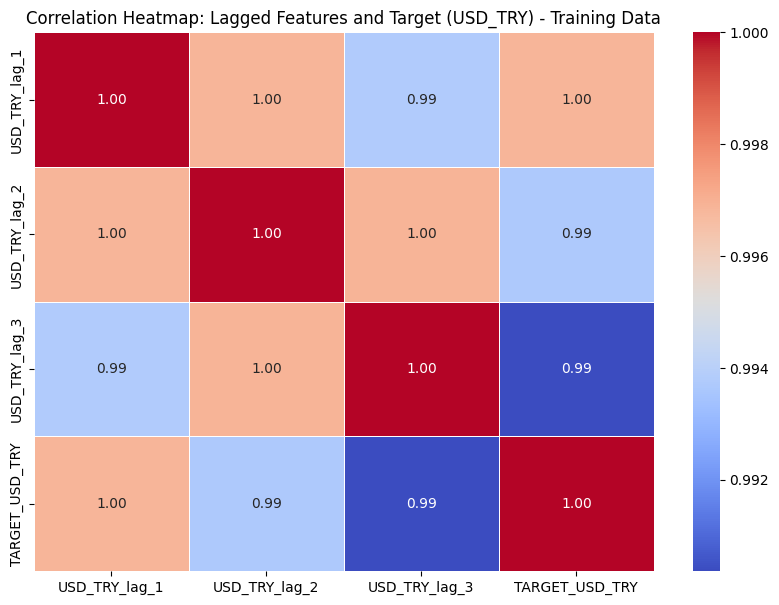

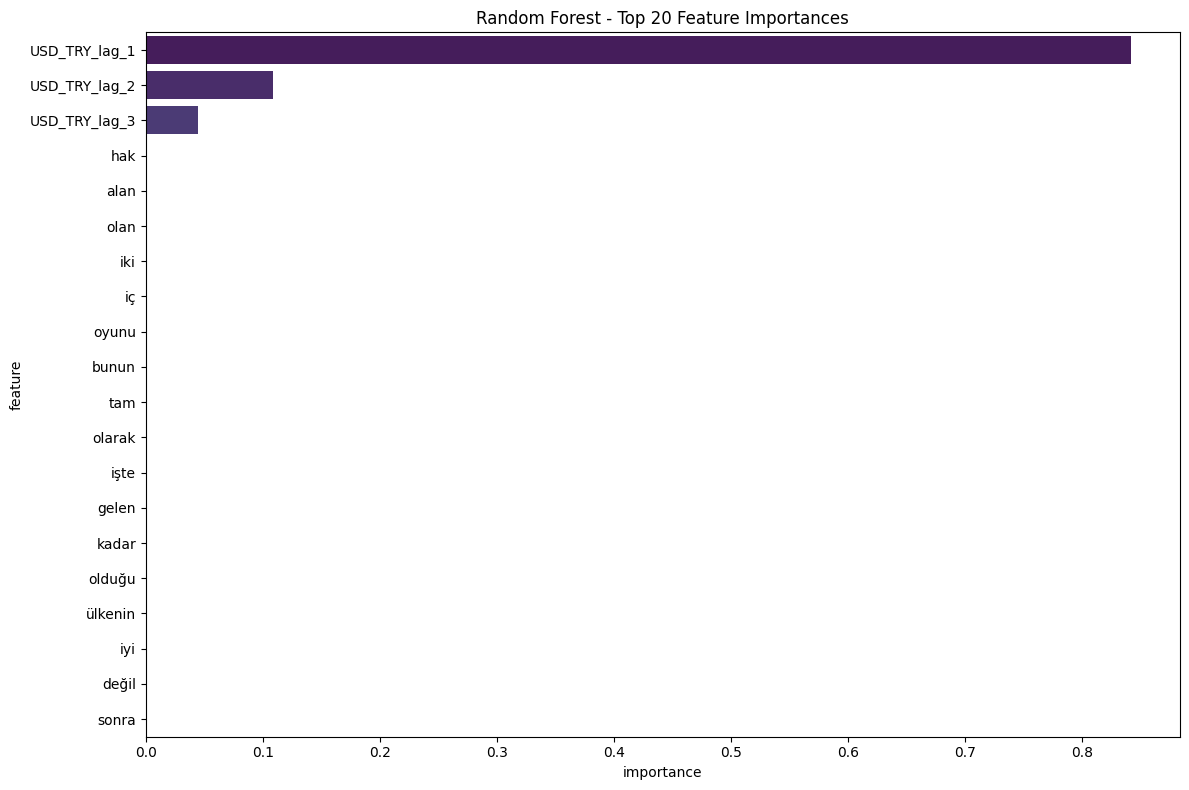

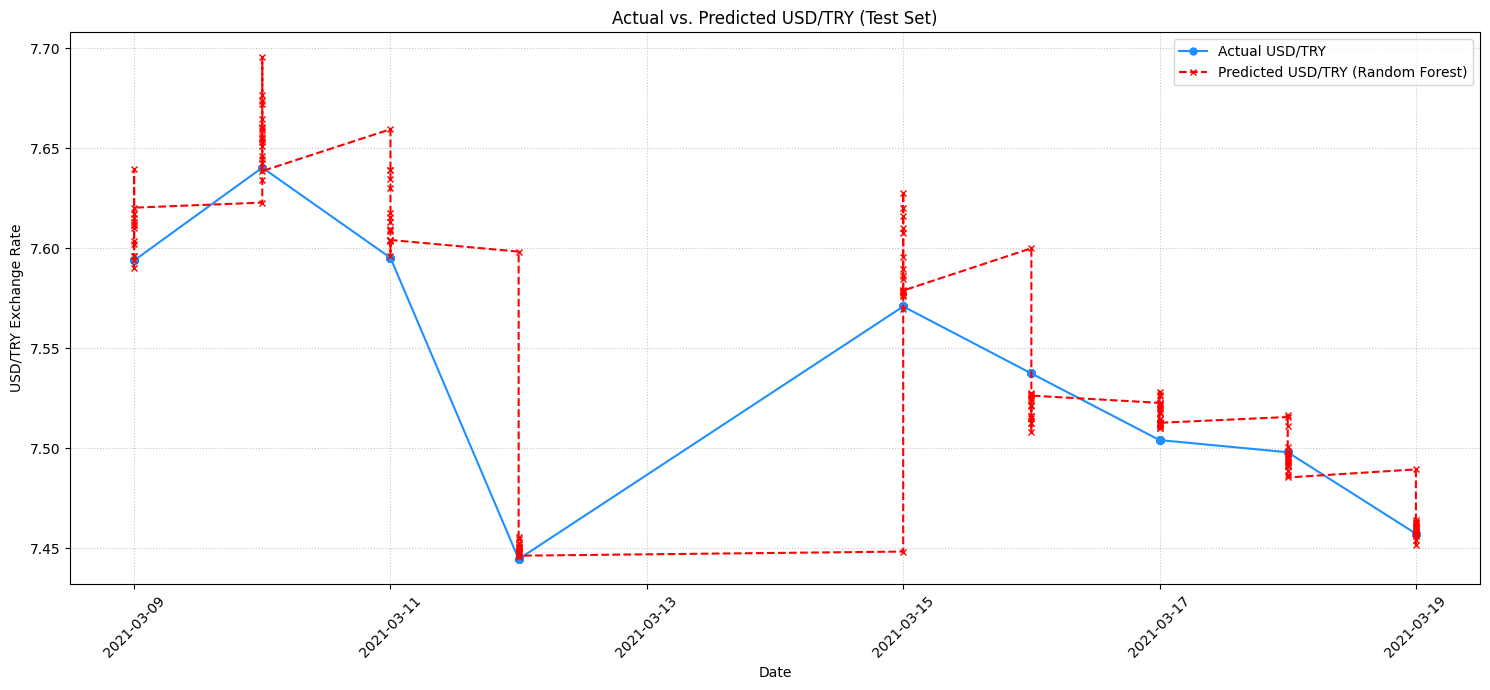

In [12]:
if best_model_instance is not None and not X_test_final.empty and not y_test.empty:
    # 1. Correlation Heatmap (for lagged features and target variable in training data)
    # It's better to compute correlation on the training set used for model building.
    lag_feature_names = [col for col in X_train_final.columns if 'USD_TRY_lag' in col]
    if lag_feature_names: # If lag features exist
        # Create a temporary DataFrame for correlation including the target variable
        # Ensure y_train has the same index as X_train_final after NaN dropping for lags
        temp_df_for_corr = X_train_final[lag_feature_names].copy()
        temp_df_for_corr['TARGET_USD_TRY'] = y_train
        
        plt.figure(figsize=(10, 7))
        sns.heatmap(temp_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Heatmap: Lagged Features and Target (USD_TRY) - Training Data')
        plt.show()
    else:
        print("\nWarning: No lag features found to create a correlation heatmap.")

    # 2. Feature Importance Plot (if the best model is tree-based)
    if hasattr(best_model_instance, 'feature_importances_'):
        importances = best_model_instance.feature_importances_
        feature_names = X_train_final.columns # Use columns from X_train_final
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, max(8, len(feature_importance_df.head(20)) * 0.4) )) # Dynamic height
        # Display top N features (e.g., top 20)
        top_n = min(20, len(feature_importance_df)) # Show at most 20 or fewer if less features
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette="viridis")
        plt.title(f'{best_model_name} - Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{best_model_name} does not have 'feature_importances_' attribute (e.g., SVR, Linear Regression).")

    # 3. Actual vs. Predicted Values Plot (for the Test Set)
    y_pred_best_model = best_model_instance.predict(X_test_final)
    
    # Ensure dates_test, y_test, and y_pred_best_model are aligned and have the same length
    # This should be handled by the NaN dropping step for X_test_final which also filters y_test and dates_test
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates_test, y_test.values, label='Actual USD/TRY', color='dodgerblue', marker='o', linestyle='-', markersize=5)
    plt.plot(dates_test, y_pred_best_model, label=f'Predicted USD/TRY ({best_model_name})', color='red', linestyle='--', marker='x', markersize=5)
    plt.title('Actual vs. Predicted USD/TRY (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('USD/TRY Exchange Rate')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping visualizations as best model is not available or test data is empty.")